In [2]:
!pip install qadence

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.8/261.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 M

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad
from torch import tan

INFO  2025-01-06 10:22:53 - pyqtorch: PyQTorch logger successfully setup with log level 20
INFO:pyqtorch:PyQTorch logger successfully setup with log level 20


# Eqn 30:
- $\frac{df}{dx} + \lambda f \left( \kappa + \tan(\lambda x) \right) = 0, \quad f(0) = 1,
$


- $\kappa$ and $\lambda$ control the exponential and sinusoidal properties of f respectively

# The analytical solution with the above boundary condition
- y(x) = $\exp(-\kappa \lambda x) \cos(\lambda x)$

In [44]:
#function to compute the analytical solution value
def analytical_solution(KAPPA, LAMBDA, points):
    return ((np.e)**(-KAPPA*LAMBDA*points))*np.cos(LAMBDA*points)

# function that solves the equation, with all the circuit and optimizer settings as inputs
def solve_diff_eqn(N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS, LAMBDA, KAPPA, fm_type, tower, n_iter, reg_penalty = 0, reg_points = tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])):

    manual_seed(404)

    ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH) #hardware efficient ansatz

    if(tower == True): #Whether to apply a tower scheme in the feature map circuit
        fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type=fm_type,  reupload_scaling = ReuploadScaling.TOWER)
    else:
        fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type=fm_type)

    obs = total_magnetization(n_qubits=N_QUBITS) #The cost function operator

    circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz)) #"Chaining the feature map and the variational circuits"
    model = QNN(circuit=circuit, observable=obs, inputs=["x"]) #setting up the model

    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam optimizer

    def reg_loss(reg_points_list, current_iter, total_iter): #Regularization loss
        diff = analytical_solution(KAPPA, LAMBDA, reg_points_list) - model(tensor(reg_points_list))
        return (1 - (current_iter/total_iter))*(diff.pow(2).mean())

    def loss_fn(inputs, outputs, current_iter, total_iter, regul_penalty): #loss function with the DE loss, boundary condition, regularization
        dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
        ode_loss = dfdx + LAMBDA*outputs*(KAPPA + tan(LAMBDA*inputs))
        boundary_loss = model(zeros_like(inputs)) - ones_like(inputs)
        return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean() + regul_penalty*reg_loss(reg_points, current_iter, total_iter)

    min_loss = np.inf #min loss needed as the optimizer doesnt reduce the loss monotonically
    best_model = model #model with the least loss

    for epoch in range(n_iter):
        opt.zero_grad()
        cp = tensor(uniform(low=-0.99, high=0.99, size=(N_POINTS, 1)), requires_grad=True).float()
        loss = loss_fn(inputs=cp, outputs=model(cp), current_iter = epoch + 1, total_iter = n_iter, regul_penalty = reg_penalty)

        if(loss.detach().numpy() < min_loss): #update the minimum loss and the best model
           min_loss = loss.detach().numpy()
           best_model = model

        loss.backward()
        opt.step()
        print(f"epoch {epoch} done, loss = {loss}")

    model = best_model #update the best model
    cp = tensor(uniform(low=-0.99, high=0.99, size=(N_POINTS, 1)), requires_grad=True).float()
    final_loss = loss_fn(cp, model(cp), 0, 1, 1).detach().numpy()

    sample_points = linspace(-1, 1, steps=100).reshape(-1, 1)
    analytic_sol = (((np.e)**(-KAPPA*LAMBDA*sample_points))*np.cos(LAMBDA*sample_points))

    dqc_sol = model(sample_points).detach().numpy()
    x_data = sample_points.detach().numpy()

    return x_data, analytic_sol, dqc_sol, min_loss, final_loss

# Solving the DE with $\kappa = 0.1, \lambda = 1$
- Using a chebysehv feature map
- 6 qubit feature map
- Depth 20 hardware efficient ansatz

In [35]:
x_data, analytic_sol, dqc_sol, min_loss, final_loss = solve_diff_eqn(N_QUBITS=6, DEPTH=20, LEARNING_RATE=0.01, N_POINTS=20, LAMBDA=1, KAPPA=0.1, fm_type="Chebyshev", tower = False, n_iter=200)

<ipython-input-32-0cb6ae1abcc1>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = analytical_solution(KAPPA, LAMBDA, reg_points_list) - model(tensor(reg_points_list))


epoch 0 done, loss = 0.8162597283461874
epoch 1 done, loss = 0.7448964713849064
epoch 2 done, loss = 0.3393384246261032
epoch 3 done, loss = 0.8056997726663954
epoch 4 done, loss = 0.11161694956209764
epoch 5 done, loss = 0.1326805937465596
epoch 6 done, loss = 0.30179124105524896
epoch 7 done, loss = 0.3807305582602836
epoch 8 done, loss = 0.3492522863006385
epoch 9 done, loss = 0.10630460577746413
epoch 10 done, loss = 0.11559373180343147
epoch 11 done, loss = 0.17667646333476536
epoch 12 done, loss = 0.07655812056690581
epoch 13 done, loss = 0.0994835578499475
epoch 14 done, loss = 0.10782997990041202
epoch 15 done, loss = 0.09754807233376626
epoch 16 done, loss = 0.08518673393957349
epoch 17 done, loss = 0.0777229853363352
epoch 18 done, loss = 0.0692426865859646
epoch 19 done, loss = 0.11384280127960027
epoch 20 done, loss = 0.08586268229668494
epoch 21 done, loss = 0.06734899802580227
epoch 22 done, loss = 0.033528201714182124
epoch 23 done, loss = 0.07374278706933045
epoch 24 do

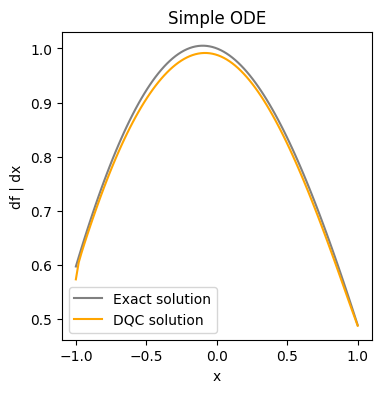

In [38]:
# plot
plt.figure(figsize=(4, 4))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df | dx")
plt.title("Simple ODE")
plt.legend()
plt.show()


# The effect of $\kappa$ on the ability of the feature map to represent the solution
- $\kappa$ values tested for: [0.1, 0.5, 1, 2]
- $\lambda$ = 1
- 6 qubit feature map
- Depth 20 hardware efficient ansatz

In [39]:
x_data_list = []
analytic_sol_list = []
dqc_sol_list = []
final_loss_list = []
min_loss_list = []

for kappa_iter in [0.1, 0.5, 1, 2]:
    x_data, analytic_sol, dqc_sol, min_loss, final_loss = solve_diff_eqn(N_QUBITS=6, DEPTH=20, LEARNING_RATE=0.01, N_POINTS=20, LAMBDA=1, KAPPA=kappa_iter, fm_type="Chebyshev", tower = False, n_iter=300)
    x_data_list.append(x_data)
    analytic_sol_list.append(analytic_sol)
    dqc_sol_list.append(dqc_sol)
    final_loss_list.append(final_loss)
    min_loss_list.append(min_loss)

<ipython-input-32-0cb6ae1abcc1>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = analytical_solution(KAPPA, LAMBDA, reg_points_list) - model(tensor(reg_points_list))


epoch 0 done, loss = 1.5437701668506558
epoch 1 done, loss = 0.5018056279588303
epoch 2 done, loss = 0.3987377513347946
epoch 3 done, loss = 0.40029243773454154
epoch 4 done, loss = 0.19814841809053726
epoch 5 done, loss = 0.09458445669873618
epoch 6 done, loss = 0.024454716528510455
epoch 7 done, loss = 0.03495477803486592
epoch 8 done, loss = 0.069893975765047
epoch 9 done, loss = 0.12228824350641436
epoch 10 done, loss = 0.1391627761750253
epoch 11 done, loss = 0.0651208808423022
epoch 12 done, loss = 0.37595916086627323
epoch 13 done, loss = 0.08156180571895522
epoch 14 done, loss = 0.05579649919747818
epoch 15 done, loss = 0.010142883704316038
epoch 16 done, loss = 0.07520880051222871
epoch 17 done, loss = 0.18923972946510548
epoch 18 done, loss = 0.07566780977742754
epoch 19 done, loss = 0.03931336666082766
epoch 20 done, loss = 0.01563142821010955
epoch 21 done, loss = 0.014697358008294312
epoch 22 done, loss = 0.01866575396745198
epoch 23 done, loss = 0.057470778875078836
epoch

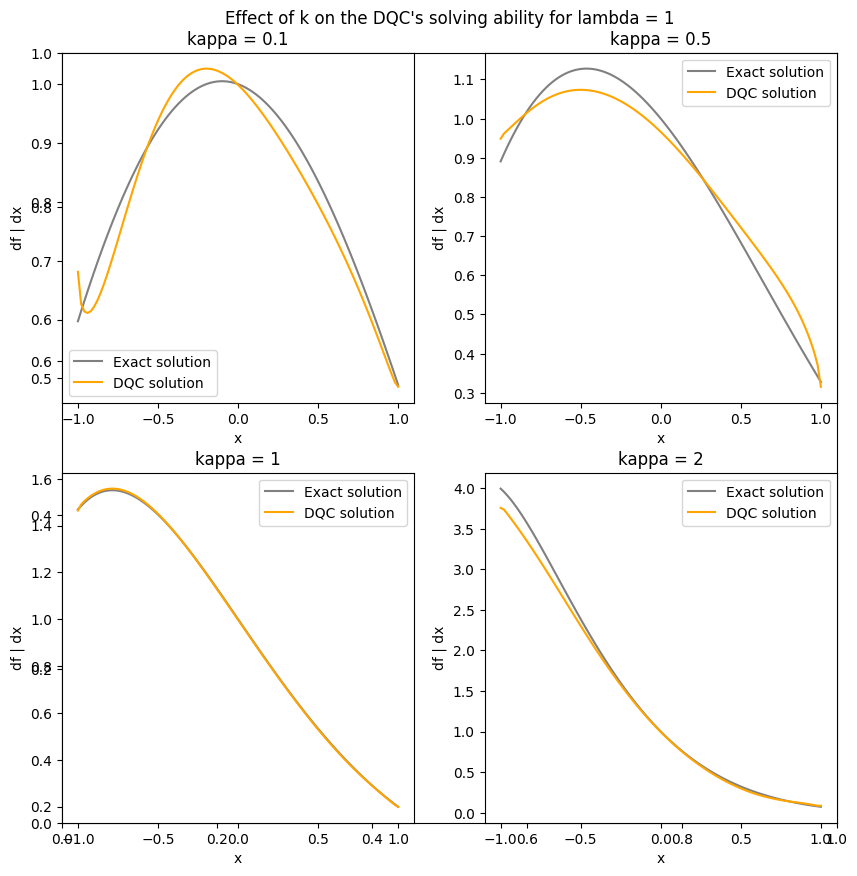

In [50]:
plt.figure(figsize = (10, 10))
plt.title("Effect of k on the DQC's solving ability for lambda = 1\n")
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(x_data_list[i], analytic_sol_list[i].flatten(), color="gray", label="Exact solution")
    plt.plot(x_data_list[i], dqc_sol_list[i].flatten(), color="orange", label="DQC solution")
    plt.xlabel("x")
    plt.ylabel("df | dx")
    plt.title(f"kappa = {[0.1, 0.5, 1, 2][i]}")
    plt.legend()
    plt.show

# References
- [Solving nonlinear differential equations with differentiable quantum circuits](https://arxiv.org/abs/2011.10395)
- [Qadence: a differentiable interface for digital-analog programs](https://arxiv.org/abs/2401.09915)